In [2]:
import os
import sqlite3
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.chained_assignment = None 


In [3]:
db_path = os.path.abspath('')
db_path = "\\".join(db_path.split("\\")[0:-1]) + "\\steam_stats.db"
conn = sqlite3.connect(db_path)


steam_stats_q = """select 
	A.*,
	B.twitch_game_id,
	C.release_date,
	C.num_dlcs,
	C.num_expansions
from steam_stats A
left join steam_twitch_mapping B on A.game = B.steam_game
left join twitch_game_info C on B.twitch_game_id = C.twitch_id"""

steam_stats = pd.read_sql_query(steam_stats_q,conn,parse_dates=["refresh_date","release_date"])
steam_stats["twitch_game_id"] = steam_stats["twitch_game_id"].astype("Int64")
developers_q = """select A.twitch_id,B.company_name
from twitch_game_involved_companies A 
left join twitch_companies B on A.company_id = B.company_id
where A.role = 'developer' """

developers = pd.read_sql_query(developers_q,conn)

print(steam_stats[["current_players","peak_today"]].describe())
steam_stats["game"].nunique()

       current_players     peak_today
count      2500.000000    2500.000000
mean      44154.622000   56805.808400
std       93438.704738  117332.667282
min        5757.000000    7536.000000
25%       11899.250000   16181.000000
50%       18877.000000   24365.000000
75%       33796.000000   41318.000000
max      894774.000000  900249.000000


123

## Top 10 games based on max daily peak

In [4]:
df = steam_stats.groupby("game").agg(
    count = ("peak_today","count"),
    max_peak = ("peak_today","max"),
    avg_current_players = ("current_players","mean"),
    release_date = ("release_date","max")
)
df["avg_current_players"] = df["avg_current_players"].round(0).astype("Int64")
df_top10 = df.sort_values("max_peak",ascending=False).head(10)
df_top10

,count,max_peak,avg_current_players,release_date
game,,,,
Counter-Strike: Global Offensive,25,900249,689915,2012-08-21
Dota 2,25,636172,490478,2013-07-09
PUBG: BATTLEGROUNDS,25,378838,248648,2017-12-20
Apex Legends,25,344142,234400,2019-02-04
Lost Ark,25,329494,280773,2018-12-04
Grand Theft Auto V,25,191400,148998,2013-09-17
MultiVersus,25,153433,81921,2022-07-19
Team Fortress 2,25,123221,102158,2007-10-09
MONSTER HUNTER RISE,25,106135,66915,2022-06-30


In [5]:
max = int(((df_top10["max_peak"].max()/1000)+50).round(0))
x_ticks = range(0,max,100)
x_labels = [str(t) + "k" for t in x_ticks]


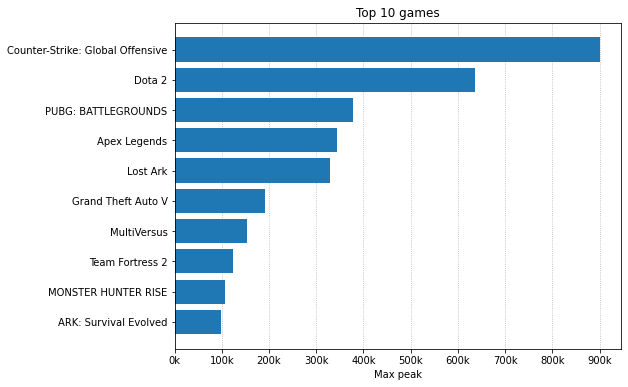

In [6]:
plt.figure(figsize=(8,6))
plt.title("Top 10 games")
plt.barh(df_top10.index.values,df_top10["max_peak"]/1000,zorder =2)
plt.gca().invert_yaxis()
plt.xlabel("Max peak")
plt.xticks(x_ticks,labels=x_labels)
plt.grid(axis = "x",linestyle = "dotted")
plt.show()

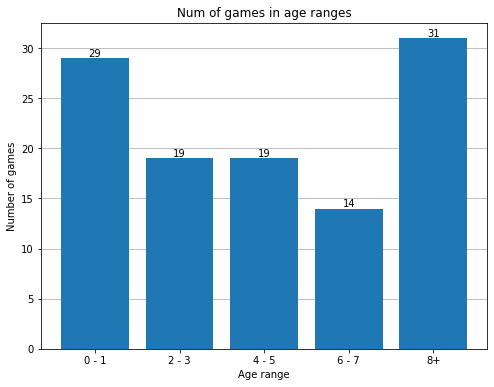

In [7]:
def age_group(age):
    if  age <2:
        return "0 - 1"
    elif age >= 2 and age < 4:
        return "2 - 3"
    elif age>=4 and age < 6:
        return "4 - 5"
    elif age>=6 and age < 8:
        return "6 - 7"
    return "8+" 

current_year = datetime.date.today().year
df = steam_stats[steam_stats["release_date"].notna()][["game","peak_today","release_date"]]
df["age"] = (pd.to_datetime('today') - df["release_date"]) / np.timedelta64(1, 'Y')
df["age_group"] = df["age"].map(age_group)
df_age = df.groupby("age_group").agg(
    num_of_games = ("game","nunique")
)

plt.figure(figsize=(8,6))
plt.title("Num of games in age ranges")
plt.ylabel("Number of games")
plt.xlabel("Age range")
b = plt.bar(df_age.index.values,df_age["num_of_games"],zorder = 2)
plt.bar_label(b,df_age["num_of_games"])
plt.grid(axis="y")
plt.show()


## Boxplot for max_peak in age groups

age_group
0 - 1    23615.0
2 - 3    19760.0
4 - 5    26120.0
6 - 7    20396.0
8+       24221.0
Name: peak_today, dtype: float64


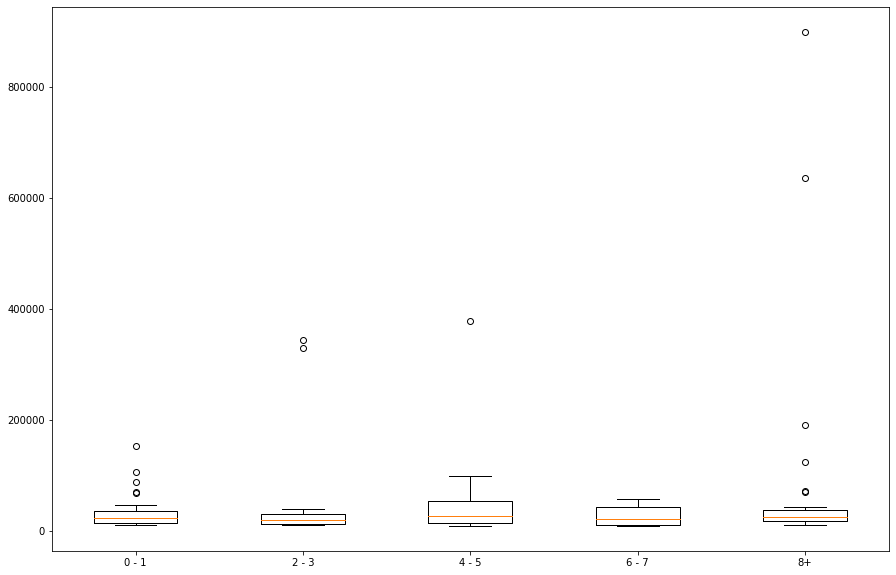

In [8]:
#top2 = df_top10.index.values.tolist()[0:2]
#df2 =df[~df["game"].isin(top2)]

df_peaks = df.groupby(["age_group","game"])["peak_today"].max()
df_peaks = df_peaks.droplevel(level=1)
print(df_peaks.groupby("age_group").median())
groups = df_peaks.index.unique().tolist()
groups
data = [df_peaks.loc[g].values.tolist() for g in groups]
plt.figure(figsize=(15,10))
plt.style.use('default')
plt.boxplot(data,labels=groups)
plt.show()


In [9]:
steam_stats[steam_stats.twitch_game_id.notna()]
#developers.info()

df = pd.merge(steam_stats[steam_stats.twitch_game_id.notna()],developers,how = "left", left_on="twitch_game_id", right_on="twitch_id")
df.groupby("company_name").agg(
    num_of
)

,refresh_date,game,current_players,peak_today,twitch_game_id,release_date,num_dlcs,num_expansions,twitch_id,company_name
0,2022-07-26 12:41:00,Counter-Strike: Global Offensive,686033,887220,1372,2012-08-21,1.0,NaN,1372.0,Valve Corporation
1,2022-07-26 12:41:00,Counter-Strike: Global Offensive,686033,887220,1372,2012-08-21,1.0,NaN,1372.0,Hidden Path Entertainment
2,2022-07-26 12:41:00,Dota 2,532586,621930,2963,2013-07-09,NaN,NaN,2963.0,Valve Corporation
3,2022-07-26 12:41:00,Lost Ark,283543,290423,26128,2018-12-04,NaN,NaN,26128.0,Tripod Studio
4,2022-07-26 12:41:00,Apex Legends,138300,336273,114795,2019-02-04,9.0,NaN,114795.0,Respawn Entertainment
...,...,...,...,...,...,...,...,...,...,...
2737,2022-07-30 09:55:00,Total War: WARHAMMER III,10553,10661,143114,2022-02-17,1.0,1.0,143114.0,The Creative Assembly
2738,2022-07-30 09:55:00,Forza Horizon 5,10496,11529,141503,2021-11-09,2.0,2.0,141503.0,Playground Games
2739,2022-07-30 09:55:00,Dinkum,10124,10564,120322,2022-07-14,NaN,NaN,120322.0,James Bendon
2740,2022-07-30 09:55:00,Divinity: Original Sin 2,10011,10489,11800,2017-09-14,NaN,NaN,11800.0,Larian Studios
